In [2]:
from nipype.algorithms.metrics import FuzzyOverlap
from nilearn.image import resample_to_img
from scipy.stats import pearsonr
from __future__ import division
import matplotlib.pyplot as plt
from collections import Counter
from matplotlib import gridspec
from nilearn import plotting
import nibabel as nib
import seaborn as sns
import pandas as pd
import numpy as np
import palettable
import json
import sys
import os

sys.path.append(os.path.join(os.environ.get("HOME"),"CNP_analysis"))
from utils import get_config, atlas
from utils.prog import log_progress as lp

%matplotlib inline

sns.set_style('white')

cols = palettable.tableau.ColorBlind_10.hex_colors
cols += palettable.tableau.PurpleGray_6.hex_colors
cols += palettable.tableau.Tableau_10.hex_colors

sns.set_palette(palettable.tableau.ColorBlind_10.mpl_colors)

basedir = os.environ.get("PREPBASEDIR")
pipelines = ['fslfeat_5.0.9','fmriprep-1.0.3']
fact = {
    'fslfeat_5.0.9': 2,
    'fmriprep-1.0.3': 3.3
}

/home/jdurnez/.local/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Smoothness

In [3]:
groupfile = os.path.join(basedir,'fmriprep_vs_feat/smoothness_group.csv')
group = pd.read_csv(groupfile,index_col=0)
subjectsfile = os.path.join(basedir,'fmriprep_vs_feat/smoothness_subjects.csv')
subjects = pd.read_csv(subjectsfile,index_col=0)

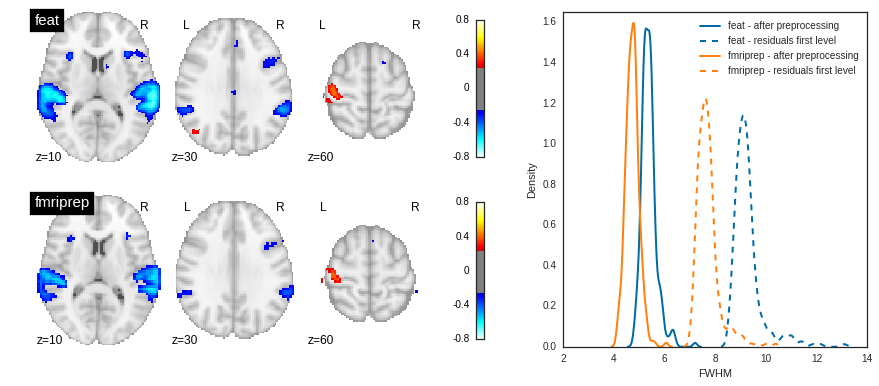

In [9]:
fig = plt.figure(figsize=(15, 6))
gs1 = gridspec.GridSpec(2, 2,
                       width_ratios=[3, 2],
                       height_ratios=[1, 1]
                       )

pipelines_labels = ['feat','fmriprep']
samplesize = 30

# FIGURE 1: SLICES

cut_coords = [10,30,60]
for idx,pipeline in enumerate(pipelines):
    ax = plt.subplot(gs1[idx, 0])
    image = os.path.join(basedir,'fmriprep_vs_feat',pipeline,"task_acm/stopsignal/zstat11_ACM_diff.nii.gz")
    plotting.plot_stat_map(image,title=pipelines_labels[idx],threshold=0.25,
                           display_mode='z',cut_coords=cut_coords,vmax=0.8,axes=ax)

# FIGURE 2: SMOOTHNESS

ax2 = plt.subplot(gs1[:, 1])
for idy,pipeline in enumerate(pipelines):
    pipelabel = pipelines_labels[idy]
    if idy==0:
        kws = {'linewidth': 2, 'color':cols[0]}
    else:
        kws = {'linewidth': 2, 'color':cols[1]}
    
    subset = subjects[subjects.pipeline==pipeline]
    subset_group = group[np.logical_and(group.pipeline==pipeline, group.samplesize==samplesize)]
    
    sns.distplot(subset.FWHM_unpr,color=cols[0],hist=False,kde_kws=dict(kws.items()+[('linestyle','-')]),
                 label="%s - after preprocessing"%pipelabel)
    sns.distplot(subset.FWHM_resid,color=cols[3],hist=False,kde_kws=dict(kws.items()+[('linestyle','--')]),
                 label="%s - residuals first level"%pipelabel)

plt.ylabel("Density")
plt.xlabel("FWHM")
plt.ylim([0,1.65])
plt.legend()    

**Figure:** 

_Left panel:_ Thresholded activation count maps for the go vs. successful stop contrast in the stopsignal task after preprocessing using either fmriprep or FSL's feat, with identical single subject modeling (with FSL's feat).  The activation count maps represent in each voxel the percentage of subjects showing a z-statistic higher than 1.65 subtracted with the percentage of subjects with a z-statistic lower than 1.65 for the positive values, and the inverse for the negative values, and therefore give an indication of the consistency over subjects of the locations of high and low values.  It can be seen that the results from both pipelines show activation in the same regions.  However, the results from FSL's feat are more smooth whereas the results from the fmriprep pipeline are more local and better aligned with the location of the grey matter.  The figures are produced using nilearn **[REF]**.

_Right panel:_ The distribution of the estimated smoothness in all subjects at different stages of the modeling pipeline for the go vs. successful stop contrast in the stopsignal task using both pipelines.  The smoothness is estimated using FSL's smoothest **[REF]** as implemented in nipype **[REF]** at two different stages: (1) after preprocessing, and (2) after modeling the task and contrast at the single subject level, where an additional smoothing kernel of 5mm is applied prior to the analysis.  The distribution is estimated with Scott's gaussian kernel density estimator**[REF?]**.  As is suggested in the left panel, this figure shows how the data preprocessed using FSL's feat are more smooth after preprocessing despite the fact that neither pipeline incorporated an explicit smoothing step.  This effect is propagated throughout the rest of the analysis.  The figures are produced using seaborn **[REF]**.

# Test-Retest measures of overlap

In [4]:
results = pd.read_csv(os.path.join(basedir,"fmriprep_vs_feat/results.csv"),index_col=0)
results['samplesize'] = [int(x) for x in results['samplesize']]
results = results[results['samplesize']%10==0]
results['pipeline_label'] = 'fmriprep'
results['pipeline_label'][results['pipeline']=='fslfeat_5.0.9'] = 'feat'


/share/PI/russpold/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


/share/PI/russpold/software/anaconda/lib/python2.7/site-packages/matplotlib/axes/_subplots.py:69: MatplotlibDeprecationWarning: The use of 0 (which ends up being the _last_ sub-plot) is deprecated in 1.4 and will raise an error in 1.5
  mplDeprecation)


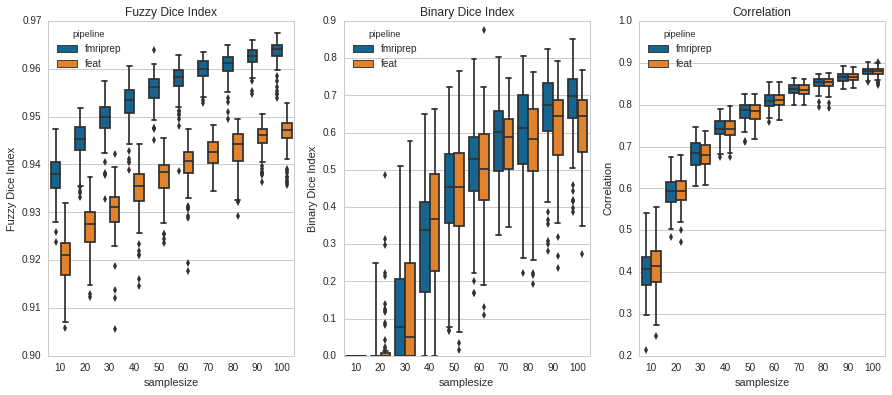

In [5]:
sns.set_style("whitegrid")
fig = plt.figure(figsize=(15,6), dpi= 100, facecolor='w', edgecolor='k')
names = ['Correlation','Fuzzy Dice Index','Binary Dice Index']
axes = {}
for idx,metric in enumerate(['correlation','fdice','dice']):
    plt.subplot(1,3,idx)
    axes[idx] = sns.boxplot(x="samplesize", y=metric, hue="pipeline_label", data=results)
    plt.ylabel(names[idx])
    plt.title(names[idx])
    leg = axes[idx].get_legend()
    new_title = 'pipeline'
    leg.set_title(new_title)

**Figure:**

Similarity between the results of the group analyses of the go vs successful stop contrast in the stopsignal task.  To produce this figure, we randomly sampled two non-overlapping groups of subjects.  These two samples are subject to a group analysis, where the data are analysed using ordinary least squared (OLS) mixed modeling using FSL's FLAME **[REF]**.  The similarity is computed between the two resulting maps.  The similarity is measured in three different ways: (1) The Fuzzy Dice Index is computed based on the (uncorrected) P-statistical map, (2) The Binary Dice index is computed based on the thresholded map, where the threshold is chosen to control the False Discovery rate at 5%, and (3) Pearson's Correlation between the Z-statistical maps.  In order to obtain a distribution rather than point estimates, this process is repeated 100 times.  We vary the samplesize n between 10 and 100, with 257 subjects in total.

The thresholded maps are very similar for both pipelines, indicating that the overlap of the significant regions is very similar.  The fuzzy dice index is higher for the data preprocessed using fmriprep, indicating that the difference between p-values in two group analyses are much closer.  Pearson's correlation between statistical maps is very similar for both pipelines.  However, it can be seen that the correlation tends to reach a plateau with increasing sample sizes, an effect also observed by **[Thirion, 2007?]** and this plateau seems to be higher when preprocessing the data using fmriprep.  This could indicate that the total trade-off between false-positives and false-negatives is higher after preprocessing the data using fmriprep.